This notebook defines a function that produces a filter spec.

In [1]:
import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
def filterSpec(N,dxMin,Lf,shape="Gaussian",X=np.pi):
    """
    Inputs: 
    N is the number of total steps in the filter
    dxMin is the smallest grid spacing - should have same units as Lf
    Lf is the filter scale, which has different meaning depending on filter shape
    shape can currently be one of two things:
        Gaussian: The target filter has kernel ~ e^{-|x/Lf|^2}
        Taper: The target filter has target grid scale Lf. Smaller scales are zeroed out. 
               Scales larger than pi*Lf/2 are left as-is. In between is a smooth transition.
    X is the width of the transition region in the "Taper" filter; per the CPT Bar&Prime doc the default is pi.
    Note that the above are properties of the *target* filter, which are not the same as the actual filter.
    
    Outputs:
    NL is the number of Laplacian steps
    sL is s_i for the Laplacian steps; units of sL are one over the units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    sB is s_i for the Biharmonic steps; units of sB are one over the units of dxMin and Lf, squared
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=sqrt(2)*pi/dxMin. Nyquist here is for a 2D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = 2*(np.pi/dxMin)**2
    # Set up target filter
    if shape == "Gaussian":
        F = lambda t: np.exp(-(sMax*(t+1)/2)*(Lf/2)**2)
    elif shape == "Taper":
        F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(np.pi/(X*Lf))**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
    else:
        print("Please input a valid shape")
        return
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Now plot the target filter and the approximate filter
    x = np.linspace(-1,1,251)
    k = np.sqrt((sMax/2)*(x+1))
    ax1 = plt.subplot(1,2,1)
    plt.plot(k,F(x),k,np.polynomial.chebyshev.chebval(x,p))
    ax2 = plt.subplot(1,2,2)
    plt.plot(k,F(x)-np.polynomial.chebyshev.chebval(x,p))
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # convert back to s in [0,sMax]
    s = (sMax/2)*(r+1)
    # Separate out the real and complex roots
    NL = np.size(s[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    sL = np.real(s[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    sB_re,indices = np.unique(np.real(s[np.where(np.abs(np.imag(r)) > 1E-12)]),return_index=True)
    sB_im = np.imag(s[np.where(np.abs(np.imag(r)) > 1E-12)])[indices]
    sB = sB_re + sB_im*1j
    return NL,sL,NB,sB

The example below uses the function to generate a Gaussian filter with 11 steps and a filter scale 5 times the grid scale. (Grid scale is arbitrarily set to 0.01 here.)
The left plot shows the Fourier transform of the target filter, along with the approximation using 11 steps.
The right plot shows the error between the target and approximate filters. The approximate filter uses 11 Laplacian steps and 0 biharmonic steps.

(11, 0)

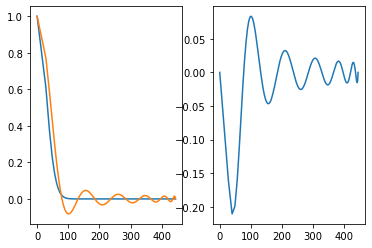

In [3]:
NL,sL,NB,sB = filterSpec(11,0.01,0.05)
NL,NB

The example below uses the function to generate a "Taper" filter (elsewhere called "sharp") with 13 steps and a filter scale 2 times the grid scale. The approximate filter uses 13 Laplacian steps and 0 biharmonic steps.

(13, 0)

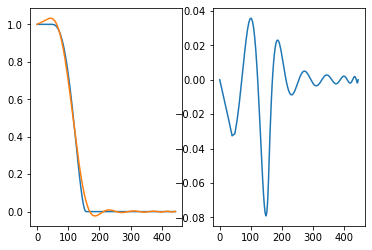

In [4]:
NL,sL,NB,sB = filterSpec(13,0.01,0.02,"Taper")
NL,NB

The example below is the same as above but with a shorter transition range of X=pi/2. The approximate filter uses 11 Laplacian steps and 1 biharmonic step.

(11, 1)

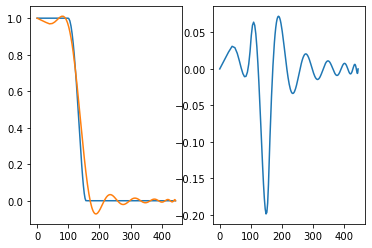

In [5]:
NL,sL,NB,sB = filterSpec(13,0.01,0.02,"Taper",X=np.pi/2)
NL,NB

The cell below shows what the weights would look like for the filter defined in the cell above if we were using a 1D domain and an equispaced grid. The same code can be re-used to compute weights for any filter spec.

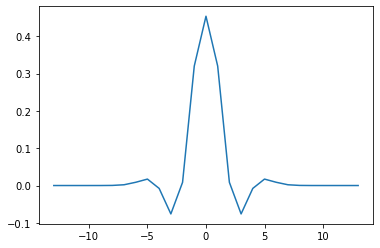

In [6]:
N = 13
L3 = 1E4*np.array([1,-2,1]) # The 1E4 in this line is 1/h^2 where h=0.01 is the assumed grid spacing.
L5 = 1E4*np.array([0,1,-2,1,0])
B = 1E8*np.array([1,-4,6,-4,1]) # The 1E8 in this line is 1/h^4
I3 = np.array([0,1,0])
I5 = np.array([0,0,1,0,0])
w = 1
for i in range(NL):
    w = np.convolve(I3 + (1/sL[i])*L3,w)
for i in range(NB):
    w = np.convolve(I5 + (2*np.real(sB[i])/np.abs(sB[i])**2)*L5 + (1/np.abs(sB[i])**2)*B, w)
plt.plot(np.arange(-N,N+1),w)

The above cell computes filter weights on a 1D equispaced grid. To implement this kind of filter you don't actually need the filter weights though. The pseudocode below shows how to implement the filter.

The code below assumes that you've run filterSpec and have NL, NB, sL, and sB. The data that you're trying to filter is in an array `data` that can be 1D, 2D, or whatever dimensionality. The pseudocode calls functions `Laplacian(input)` and `Biharmonic(input)` that compute the Laplacian and biharmonic, respectively. This is where all the dimensionality and non-uniformity of the grid are hidden, as well as boundary conditions. I'm not at this point sure if it's better to do the NL loop first or the NB loop first, or if it matters.

In [ ]:
dataBar = data # Initialize the filtering process
for i in range(NL):
    tempL = Laplacian(dataBar) # Compute Laplacian
    dataBar = dataBar + (1/sL[i])*tempL # Update filtered field
for i in range(NB):
    tempL = Laplacian(dataBar) # Compute Laplacian
    tempB = Biharmonic(dataBar) # Compute Biharmonic. If boundary conditions permit you could replace this by
                                # tempB = Laplacian(tempL)
    dataBar = dataBar + (2*np.real(sB[i])/np.abs(sB[i])**2)*tempL + (1/np.abs(sB[i])**2)*tempB